In [2]:
from ultralytics import YOLO
from dotenv import load_dotenv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import r2_score, mean_squared_error

load_dotenv(".env")
DIR_SRC = os.getenv('DIR_SRC')
DIR_DATA = os.getenv("DIR_DATA")
DIR_DENSE = os.path.join(DIR_SRC, "runs", "detect", "b01-dense")
model_s2 = YOLO("out/yolo8n_study2.pt")
sns.set("notebook")

In [4]:
def read_counts(dir_labels):
    ls_txt = os.listdir(dir_labels)
    ls_txt = [os.path.join(dir_labels, f) for f in ls_txt]
    ls_txt.sort()
    ls_filenames = [os.path.splitext(f)[0] for f in ls_txt]
    ls_filenames = [os.path.basename(f) for f in ls_filenames]
    ls_counts = []
    for f in ls_txt:
        with open(f, "r") as file:
            lines = file.readlines()
            ls_counts += [len(lines)]
    return ls_counts, ls_filenames

def r_rmse(df):
    # correlation r
    cor = df["obs"].corr(df["pre"])
    rmse = mean_squared_error(df["obs"], df["pre"], squared=False)
    rmspe = rmse / df["obs"].mean()
    return cor**2, rmse, rmspe

In [9]:
df_lbs = pd.read_csv(os.path.join(DIR_DENSE, "b01-dense.csv"))
df_lbs.head()

,filename,trt,date,time,obs
0,t1-A1_1,Virus,2024-02-28,5:00,1063
1,t1-A1_3,Virus,2024-02-28,17:00,1157
2,t1-A1_5,Virus,2024-03-01,5:00,1186
3,t1-A1_7,Virus,2024-03-01,17:00,967
4,t1-A1_8,Virus,2024-03-02,5:00,399


In [6]:
ls_pre, ls_pre_f = read_counts(os.path.join(DIR_DENSE, "labels"))

In [12]:
df_pre = pd.DataFrame(
    {"filename": ls_pre_f, "pre": ls_pre},
    columns=["filename", "pre"])
df_pre.head()


,filename,pre
0,t1-A1_1,1657
1,t1-A1_10,592
2,t1-A1_11,1727
3,t1-A1_12,1694
4,t1-A1_13,1720


In [55]:
df_merge = pd.merge(df_lbs, df_pre, on="filename")
df_merge.head()

,filename,trt,date,time,obs,pre
0,t1-A1_1,Virus,2024-02-28,5:00,1063,1657
1,t1-A1_3,Virus,2024-02-28,17:00,1157,1670
2,t1-A1_5,Virus,2024-03-01,5:00,1186,1713
3,t1-A1_7,Virus,2024-03-01,17:00,967,719
4,t1-A1_8,Virus,2024-03-02,5:00,399,631


/opt/homebrew/Caskroom/miniconda/base/envs/pyniche/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


(0.9376321975882002, 465.0445219625831, 0.46889992131562264)

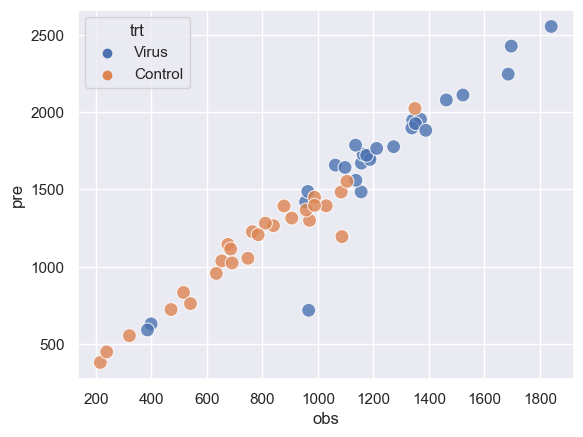

In [125]:
# scatter plot
g = sns.scatterplot(data=df_merge, 
                    x="obs", y="pre", hue="trt",
                    s=100, alpha=.8)
plt.savefig(os.path.join(DIR_SRC, "out/plot_s2.png"), dpi=300)
r_rmse(df_merge)

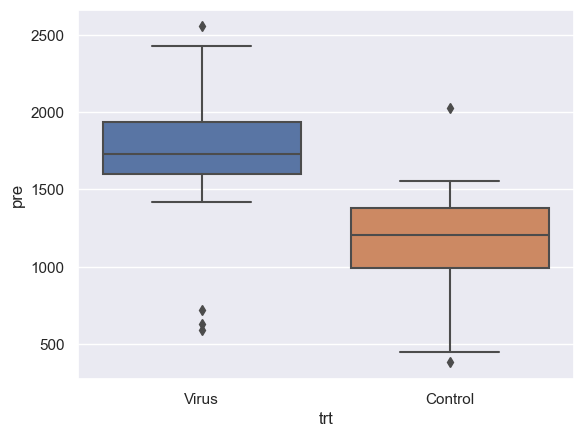

In [45]:
# scatter plot
g = sns.boxplot(data=df_merge,
                x="trt", y="pre")
plt.savefig(os.path.join(DIR_SRC, "out/plot_s2_box.png"), dpi=300)

In [86]:
# datetime
# date: 2024-02-28
# time: 17:00
# datetime: 2024-02-28 17:00
import datetime
df_merge["datetime"] = pd.to_datetime(df_merge["date"] + " " + df_merge["time"])
df_merge_long = df_merge.loc[:, ["trt", "datetime", "obs", "pre"]].\
    melt(id_vars=["trt", "datetime"], var_name="type", value_name="count")
df_merge_long["datetime"] = pd.to_datetime(df_merge_long["datetime"])
df_merge_long.head()

,trt,datetime,type,count
0,Virus,2024-02-28 05:00:00,obs,1063
1,Virus,2024-02-28 17:00:00,obs,1157
2,Virus,2024-03-01 05:00:00,obs,1186
3,Virus,2024-03-01 17:00:00,obs,967
4,Virus,2024-03-02 05:00:00,obs,399


/opt/homebrew/Caskroom/miniconda/base/envs/pyniche/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniconda/base/envs/pyniche/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniconda/base/envs/pyniche/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniconda/base/envs/pyniche/lib/python3.11/site-packages/seaborn/_ol

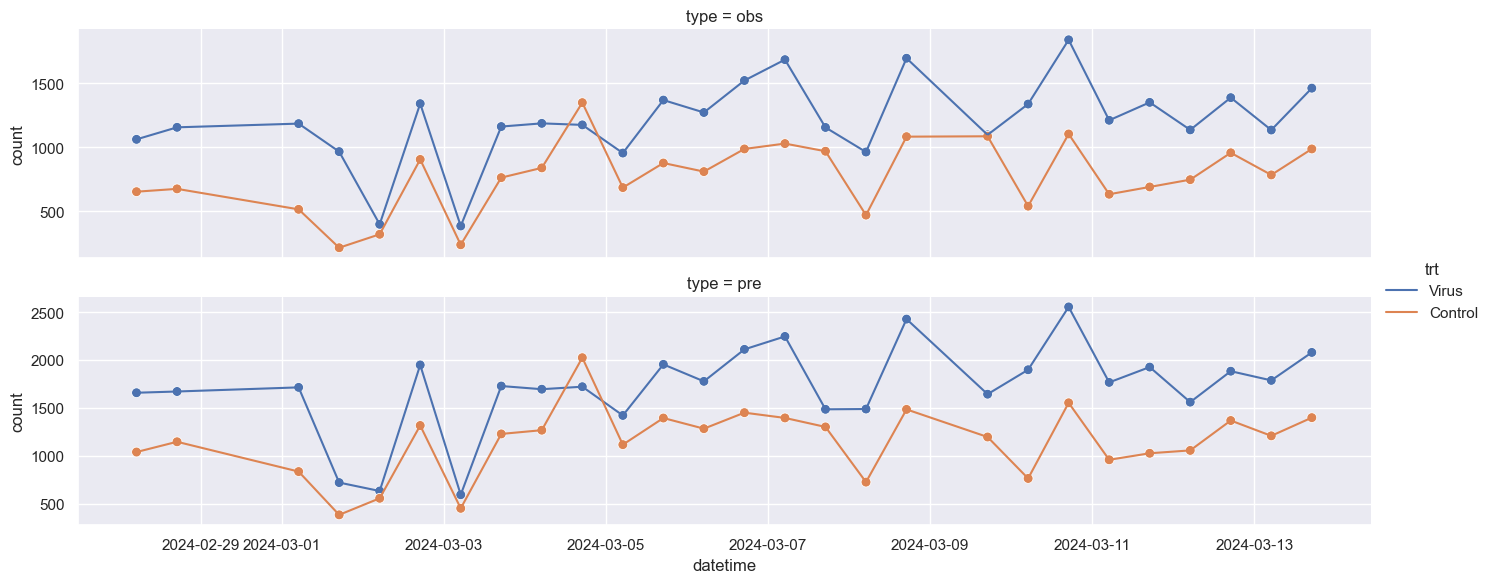

In [124]:

# facet
g = sns.FacetGrid(df_merge_long, row="type", hue="trt", sharey=False)
g.figure.set_size_inches(14, 6)
g.map_dataframe(sns.scatterplot, x="datetime", y="count", 
                # style="type", style_order=["pre", "obs"],
                size="type", sizes=(50, 50), size_order=["obs", "pre"],
)                
g.map_dataframe(sns.lineplot, x="datetime", y="count", 
                # style="type", style_order=["pre", "obs"],
                # alpha=.5
)
g.add_legend()
g
plt.savefig(os.path.join(DIR_SRC, "out/plot_s2_time.png"), dpi=300)